# General matching plan

We want to match NYMGs from Moca with Gaia DR3 (GDR3). To do so, we first notice that more than $95\%$ of Moca stars belongs to massive surveys (2MASS, GDR1, GDR2, GDR3 or WISE). Then, because GDR2 is the Gaia data release with propper motion that has the closest epoch to these surveys, we can propagate GDR2 solar neighborhood to the epochs of these catalogues and match all the stars of the NYMGs to GDR2 and then from DR2 to DR3.

However, it can happen that a star $\mathcal{S}$ from Moca is in two different surveys at the same time (for example GDR1 and 2MASS). For this reason, we must define a hierarchy of surveys. The criteria used in this code is to prioritize the survey with the closest epoch to GDR3 epoch.

When more than one star from a same survey match with one star from Moca, we only select the closest star to the Moca star in the sky.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import warnings
from scipy import interpolate
from astropy import coordinates
from astropy.coordinates import Galactic
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from mocapy import *
from astropy.coordinates import LSR

sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

/tmp/ipykernel_10774/102695962.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


# Data loading

In [70]:
gdr2  = pd.read_csv('input_cat/gaiadr2_200pc.csv',usecols=["source_id",
                                                         "ra",
                                                         "dec",
                                                         "l",
                                                         "b",
                                                         "parallax",
                                                         "parallax_error",
                                                         "pmra",
                                                         "pmdec",
                                                         "radial_velocity",
                                                         "radial_velocity_error",
                                                         "phot_g_mean_flux",
                                                         "phot_g_mean_flux_error",
                                                         "phot_g_mean_mag",
                                                         "phot_bp_mean_mag",
                                                         "phot_rp_mean_mag",
                                                          "pmra_error",
                                                          "pmdec_error"])
gdr3  = pd.read_csv('input_cat/gaiaDR3_200pc.csv',usecols=["source_id",
                                                         "ra",
                                                         "dec",
                                                         "l",
                                                         "b",
                                                         "parallax",
                                                         "parallax_error",
                                                         "pmra",
                                                         "pmdec",
                                                         "radial_velocity",
                                                         "radial_velocity_error",
                                                         "phot_g_mean_flux",
                                                         "phot_g_mean_flux_error",
                                                         "phot_g_mean_mag",
                                                         "phot_bp_mean_mag",
                                                         "phot_rp_mean_mag"])

gdr3RVMSPMS = pd.read_csv('builded_or_modified_cat/gdr3RVMSPMS.csv')

gdr3MSPMS = pd.read_csv('builded_or_modified_cat/gdr3MSPMS.csv')

In [3]:
gdr3MSPMS = gdr3MSPMS[gdr3MSPMS.pmraLSR**2+gdr3MSPMS.pmdecLSR**2 < (gdr3MSPMS.pmraLSR**2+gdr3MSPMS.pmdecLSR**2).quantile(0.8)]

(-80.0, 80.0)

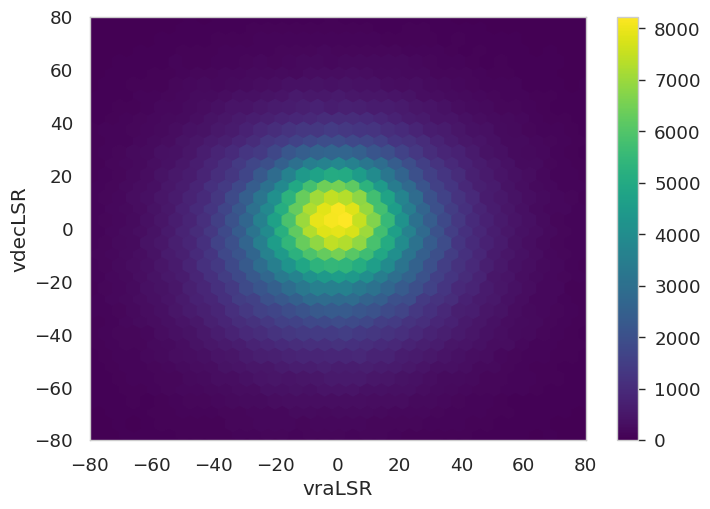

In [79]:
gogField.plot.hexbin('vraLSR','vdecLSR',gridsize=200,cmap='viridis')
plt.xlim(-80,80)
plt.ylim(-80,80)

In [4]:
Av = 4.74047
gdr3MSPMS['vraLSR'] = Av*gdr3MSPMS.pmraLSR/gdr3MSPMS.parallax
gdr3MSPMS['vdecLSR'] = Av*gdr3MSPMS.pmdecLSR/gdr3MSPMS.parallax

(-80.0, 80.0)

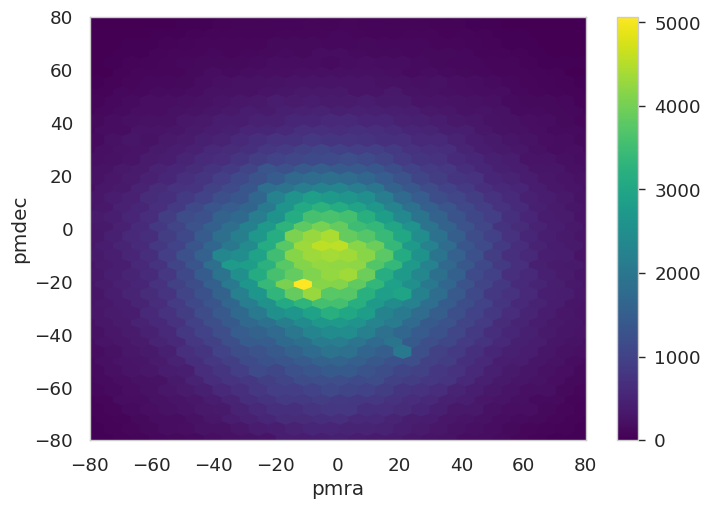

In [5]:
gdr3MSPMS.plot.hexbin('pmra','pmdec',gridsize=100,cmap='viridis')
plt.xlim(-80,80)
plt.ylim(-80,80)

<Axes: xlabel='vraLSR', ylabel='vdecLSR'>

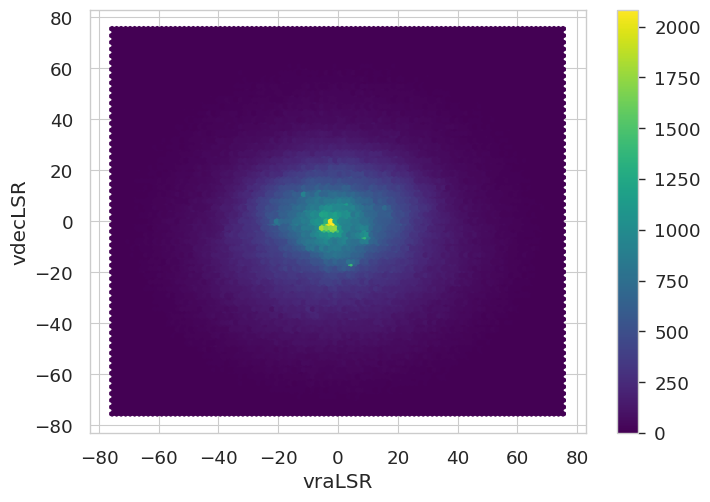

In [6]:
gdr3MSPMS.plot.hexbin('vraLSR','vdecLSR',gridsize=100,cmap='viridis')
# plt.xlim(-50,50)
# plt.ylim(-50,50)

(-200.0, 200.0)

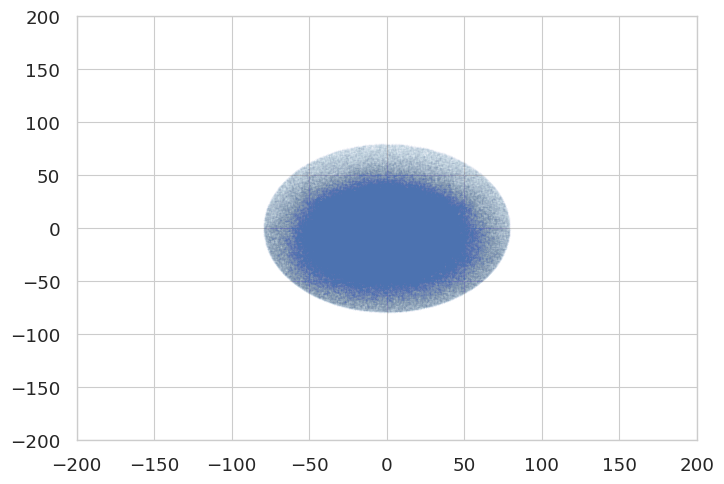

In [7]:
plt.scatter(gdr3MSPMS.pmraLSR,gdr3MSPMS.pmdecLSR,s=0.0001)
plt.xlim(-200,200)
plt.ylim(-200,200)

# General variables definition

In [8]:
nymgNames        = ['BPMG','COL','OCT','PL8','THA','TWA']
nymgNamesCommand = "moca_aid='"+nymgNames[0]+"'"
for i in np.arange(1,len(nymgNames),1):
    nymgNamesCommand += " OR moca_aid='"+nymgNames[i]+"'"
nymgAges              = [24,42,35,60,45,10]
surveysInformation    = pd.DataFrame({'surveyName':['dr3','dr2','dr1','wise','tmass'],
                                      'epoch':[2016.0,2015.5,2015.0,2010.0,1998.0],
                                      'surveyID':['gaiadr3_source_id','gaiadr2_source_id','g1_ra','allwise_designation','tmass_designation'],
                                      'raColumn':['g3_ra','g2_ra','g1_ra','aw_ra','tm_ra'],
                                      'decColumn':['g3_dec','g2_dec','g1_dec','aw_dec','tm_dec']})

In [9]:
#Create a moca engine object
moca = MocaEngine()

# table with probabilities
banyanObjects = moca.query("SELECT * FROM calc_banyan_sigma WHERE "+nymgNamesCommand)

# table with all the surveys information
mocaObjects = moca.query("SELECT * FROM summary_all_objects WHERE "+nymgNamesCommand)

# we join the probabilities information with the surveys information
mocaObjects   = mocaObjects.set_index(mocaObjects.moca_oid).drop_duplicates('moca_oid')
banyanObjects = banyanObjects.set_index(banyanObjects.moca_oid).drop_duplicates('moca_oid')
mocaObjects   = pd.concat([mocaObjects,banyanObjects.ya_prob],axis=1,join='inner')

In [10]:
mocaSurveys = mocaObjects[(mocaObjects.gaiadr3_source_id.isnull().values == False) |
                          (mocaObjects.gaiadr2_source_id.isnull().values == False) |
                          (mocaObjects.tmass_designation.isnull().values == False) |
                          (mocaObjects.allwise_designation.isnull().values == False)]
mocaSurveys = mocaSurveys.set_index(mocaSurveys.moca_oid)

In [11]:
mocaSurveys.shape[0]/mocaObjects.shape[0]

0.9952352590827874

# Sky positions propagation through GDR2 proper motions

In [12]:
icrsDr2 = SkyCoord(ra=gdr2.ra.to_numpy()*u.deg,
                   dec=gdr2.dec.to_numpy()*u.deg, 
                   distance=1000/(gdr2.parallax.to_numpy()*u.mas),
                   pm_ra_cosdec=gdr2.pmra.to_numpy()*u.mas/u.yr, 
                   pm_dec=gdr2.pmdec.to_numpy()*u.mas/u.yr,
                   frame='icrs',
                   obstime=Time(f"J{surveysInformation[surveysInformation.surveyName == 'dr2'].epoch.iloc[0]}"))

In [13]:
for i in np.arange(0,surveysInformation.shape[1],1):
    surveyName  = surveysInformation.surveyName.iloc[i]
    epoch       = surveysInformation.epoch.iloc[i]
    if surveyName != 'dr2':
        Dr2ToSurvey = icrsDr2.apply_space_motion(new_obstime=Time(f"J{epoch}"))
    
        gdr2['ra_'+surveyName] = pd.DataFrame(Dr2ToSurvey.ra)
        gdr2['dec_'+surveyName] = pd.DataFrame(Dr2ToSurvey.dec)
    else:
        gdr2['ra_'+surveyName] = gdr2.ra
        gdr2['dec_'+surveyName] = gdr2.dec

# First match with GDR3 source IDs

In [14]:
mocaGdr3Match                   = mocaSurveys[mocaSurveys.gaiadr3_source_id.isnull().values == False][['moca_oid','moca_aid','gaiadr3_source_id','ya_prob']]
mocaGdr3Match.gaiadr3_source_id = pd.to_numeric(mocaGdr3Match.gaiadr3_source_id)
mocaGdr3Match                   = mocaGdr3Match.drop_duplicates('gaiadr3_source_id')
mocaGdr3Match                   = mocaGdr3Match.set_index(mocaGdr3Match.gaiadr3_source_id)
gdr3                            = gdr3.set_index(gdr3.source_id)
mocaGdr3Match                   = pd.concat([mocaGdr3Match.drop('gaiadr3_source_id',axis=1),gdr3],axis=1,join='inner')
mocaSurveys                     = mocaSurveys[~mocaSurveys.moca_oid.isin(mocaGdr3Match.moca_oid)]

# Sky matching between GDR2 and Moca survey stars

In [15]:
# We sort the rows of the surveys information dataframe by epoch to build the hierarchy of surveys
surveysInformation = surveysInformation.sort_values('epoch',ascending=False)

gdr2NymgsMatch     = pd.DataFrame()
gdr2               = gdr2.set_index(gdr2.source_id) 

# We start from i=1 because this corresponds to the special case of GDR3 that we previously matched using GDR3 IDs
for i in np.arange(1,surveysInformation.shape[1],1):
    surveyName     = surveysInformation.surveyName.iloc[i]
    nymgStars      = mocaSurveys[mocaSurveys[surveysInformation.raColumn.iloc[i]].isnull().values == False]

    gdr2Survey     = gdr2[gdr2['ra_'+surveyName].isnull().values == False]
    
    nymgsCoords    = coordinates.ICRS(ra              = nymgStars[surveysInformation.raColumn.iloc[i]].to_numpy()*u.degree,
                                      dec             = nymgStars[surveysInformation.decColumn.iloc[i]].to_numpy()*u.degree)
    gdr2Coords     = coordinates.ICRS(ra              = gdr2Survey['ra_'+surveyName].to_numpy()*u.degree,
                                      dec             = gdr2Survey['dec_'+surveyName].to_numpy()*u.degree)
    nymgsMatchGdr2 = match_coordinates_sky(nymgsCoords, gdr2Coords, nthneighbor=1, storekdtree=u'_kdtree_sky')

    nymgsMatchGdr2 = pd.DataFrame({'gdr2Row':nymgsMatchGdr2[0],
                                   'angleSeparation':nymgsMatchGdr2[1],
                                   'moca_oid':nymgStars.moca_oid,
                                   'moca_aid':nymgStars.moca_aid,
                                   'ya_prob':nymgStars.ya_prob})
    
    rows           = nymgsMatchGdr2.gdr2Row.unique()
    finalSubMatch  = pd.DataFrame(columns=nymgsMatchGdr2.columns)
    for j in np.arange(0,rows.shape[0],1):
        row                   = rows[j]
        nymgsMatchGdr2Row     = nymgsMatchGdr2[nymgsMatchGdr2.gdr2Row == row]
        if nymgsMatchGdr2Row.shape[0] > 1:
            rowTokeep         = nymgsMatchGdr2Row[nymgsMatchGdr2Row.angleSeparation == nymgsMatchGdr2Row.angleSeparation.min()].gdr2Row.iloc[0]
            nymgsMatchGdr2Row = nymgsMatchGdr2[nymgsMatchGdr2.gdr2Row == rowTokeep]
        finalSubMatch         = pd.concat([finalSubMatch,nymgsMatchGdr2Row],axis=0).reset_index(drop=True)
    
    mocaSurveys               = mocaSurveys[~mocaSurveys.moca_oid.isin(finalSubMatch.moca_oid)]
    gdr2NymgsMatch            = pd.concat([gdr2NymgsMatch,finalSubMatch],axis=0).reset_index(drop=True)

In [16]:
gdr2NymgsMatch = gdr2NymgsMatch.drop_duplicates('gdr2Row')
gdr2NymgsMatch = gdr2NymgsMatch.set_index(gdr2NymgsMatch.gdr2Row)
gdr2           = gdr2.reset_index(drop=True)
gdr2NymgsMatch = pd.concat([gdr2[['source_id','ra_dr3','dec_dr3']],gdr2NymgsMatch],axis=1,join='inner')

# Sky match between matched stars propagated to GDR2 and GDR3

In [17]:
gdr2MatchCoords = coordinates.ICRS(ra              = gdr2NymgsMatch.ra_dr3.to_numpy()*u.degree,
                                   dec             = gdr2NymgsMatch.dec_dr3.to_numpy()*u.degree)
gdr3Coords      = coordinates.ICRS(ra              = gdr3.ra.to_numpy()*u.degree,
                                   dec             = gdr3.dec.to_numpy()*u.degree)
gdr3Match       = match_coordinates_sky(gdr2MatchCoords, gdr3Coords, nthneighbor=1, storekdtree=u'_kdtree_sky')
gdr3Match       = pd.DataFrame({'gdr3Row':gdr3Match[0],
                                'angleSeparation':gdr3Match[1],
                                'moca_oid':gdr2NymgsMatch.moca_oid,
                                'moca_aid':gdr2NymgsMatch.moca_aid,
                                'ya_prob':gdr2NymgsMatch.ya_prob})

gdr3Match       = pd.concat([gdr3Match[['moca_oid','moca_aid','ya_prob']],gdr3],axis=1,join='inner').reset_index(drop=True)
mocaGdr3Match   = pd.concat([mocaGdr3Match,gdr3Match],axis=0).reset_index(drop=True)

In [18]:
mocaGdr3Match

,moca_oid,moca_aid,ya_prob,source_id,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,l,b
0,29,BPMG,79.3387,2962658549471532672,76.706442,-21.584630,50.581137,0.103825,68.241550,-11.617803,7.187092e+05,1377.237700,11.045983,11.453994,8.757877,NaN,NaN,222.487851,-32.175663
1,32,BPMG,99.0740,6724105660828668032,271.707972,-43.425199,22.675314,0.070973,-1.187014,-101.242616,1.000365e+08,83173.160000,5.686970,5.360215,5.085796,NaN,NaN,349.447182,-10.861474
2,34,BPMG,87.2623,6792436799477051904,310.464731,-32.437515,101.972390,0.077015,296.907591,-301.429081,2.708643e+06,1547.378000,9.605488,11.243916,8.117472,-8.083389,1.600892,11.138068,-36.344336
3,155,BPMG,75.9603,3290081906654767616,76.979840,8.401766,18.673584,0.017159,18.247276,-60.289698,3.652720e+06,1412.928500,9.280826,9.678857,8.675517,10.910321,0.180370,192.762838,-18.522039
4,177,BPMG,99.0005,6697858840776095616,302.223833,-35.330361,22.333708,0.059816,50.029355,-83.272344,1.390947e+05,142.494140,12.829090,14.011961,11.028779,-31.561666,4.959283,5.982019,-30.294206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,8022,TWA,83.9921,6152893526035165312,191.934281,-38.279658,11.941856,0.347004,-44.726540,-21.562730,3.402715e+02,1.315795,19.357803,21.685940,17.840471,NaN,NaN,302.133238,24.586353
1161,8054,TWA,94.2659,6139583907716775936,192.698760,-42.530297,10.199144,0.027659,-39.360851,-19.842592,2.410806e+04,17.002195,14.731961,16.518847,13.459710,NaN,NaN,302.805605,20.341295
1162,8072,TWA,51.6274,6155574513340367616,193.362342,-35.070990,11.878495,0.022255,-47.034042,-25.093603,1.201876e+05,76.425010,12.987718,14.339603,11.838443,3.589663,7.454065,303.397178,27.798943
1163,8231,TWA,99.0790,6136589834475210752,199.370394,-42.933077,10.529749,0.031637,-40.275435,-23.152382,1.004844e+07,2908.212000,8.182120,8.396667,7.806514,7.763700,0.304040,307.990371,19.682730


In [19]:
# We compute the LSR proper motions, to do so, we set all RVs NaNs to 0
icrs            = coordinates.ICRS(ra              = mocaGdr3Match["ra"].to_numpy()*u.degree,
                                   dec             = mocaGdr3Match["dec"].to_numpy()*u.degree,
                                   distance        = (1000/mocaGdr3Match["parallax"]).to_numpy()*u.pc,
                                   pm_ra_cosdec    = mocaGdr3Match["pmra"].to_numpy()*u.mas/u.yr,
                                   pm_dec          = mocaGdr3Match["pmdec"].to_numpy()*u.mas/u.yr,
                                   radial_velocity = mocaGdr3Match["radial_velocity"].fillna(0).to_numpy()*u.km/u.s)

# We transform from ICRS to LSR
lsr                                = icrs.transform_to(LSR())
mocaGdr3Match['pmraLSR']                    = pd.DataFrame(lsr.pm_ra_cosdec)
mocaGdr3Match['pmdecLSR']                   = pd.DataFrame(lsr.pm_dec)
mocaGdr3Match['vraLSR'] = Av*mocaGdr3Match.pmraLSR/mocaGdr3Match.parallax
mocaGdr3Match['vdecLSR'] = Av*mocaGdr3Match.pmdecLSR/mocaGdr3Match.parallax
mocaGdr3Match['vra'] = Av*mocaGdr3Match.pmra/mocaGdr3Match.parallax
mocaGdr3Match['vdec'] = Av*mocaGdr3Match.pmdec/mocaGdr3Match.parallax

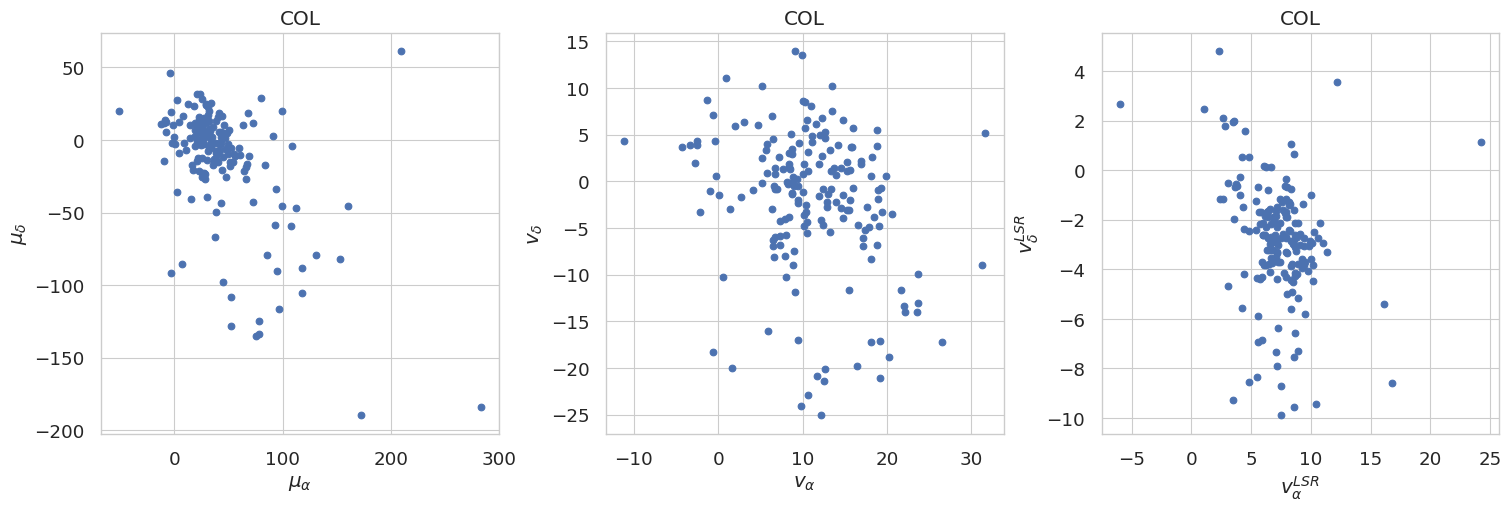

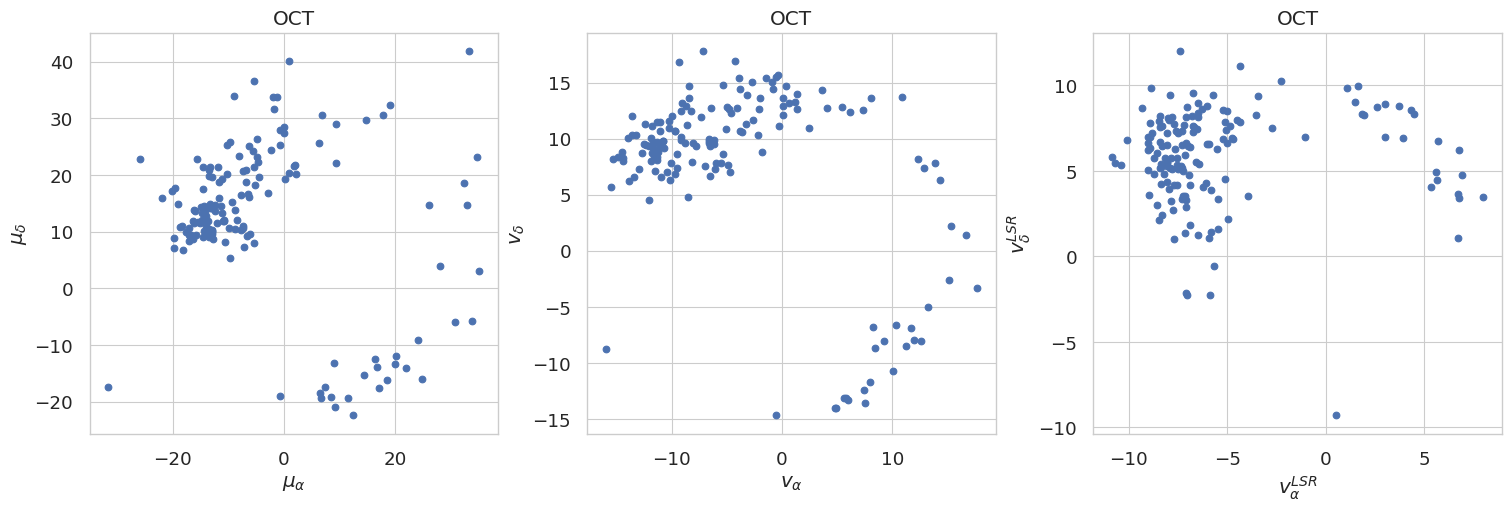

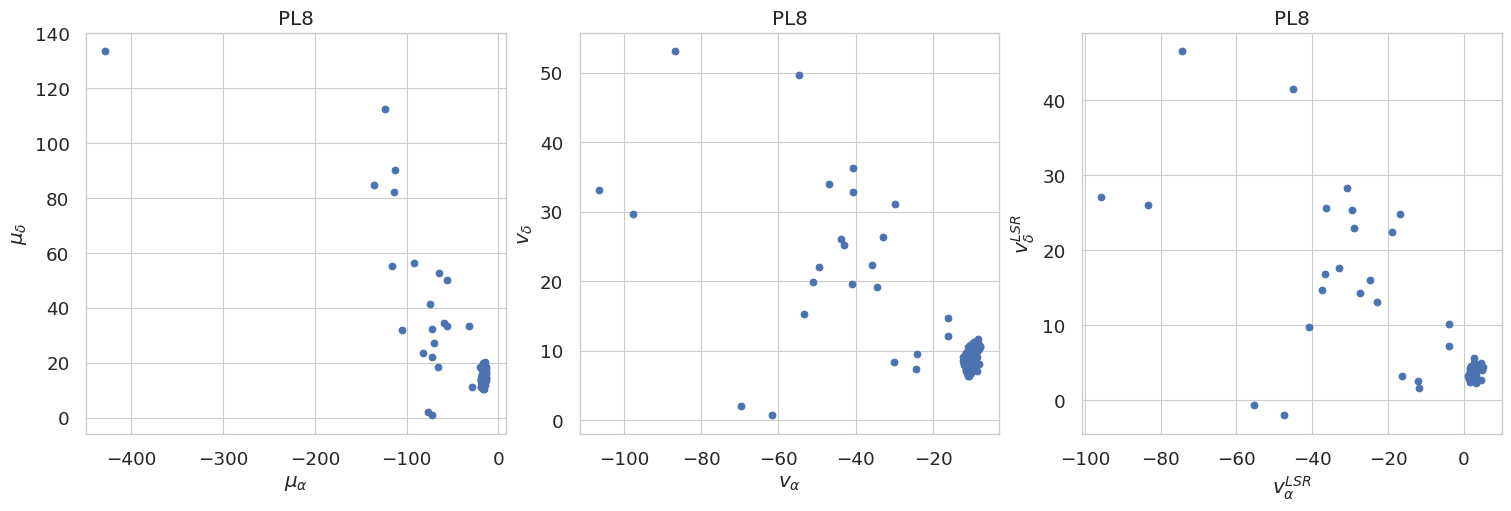

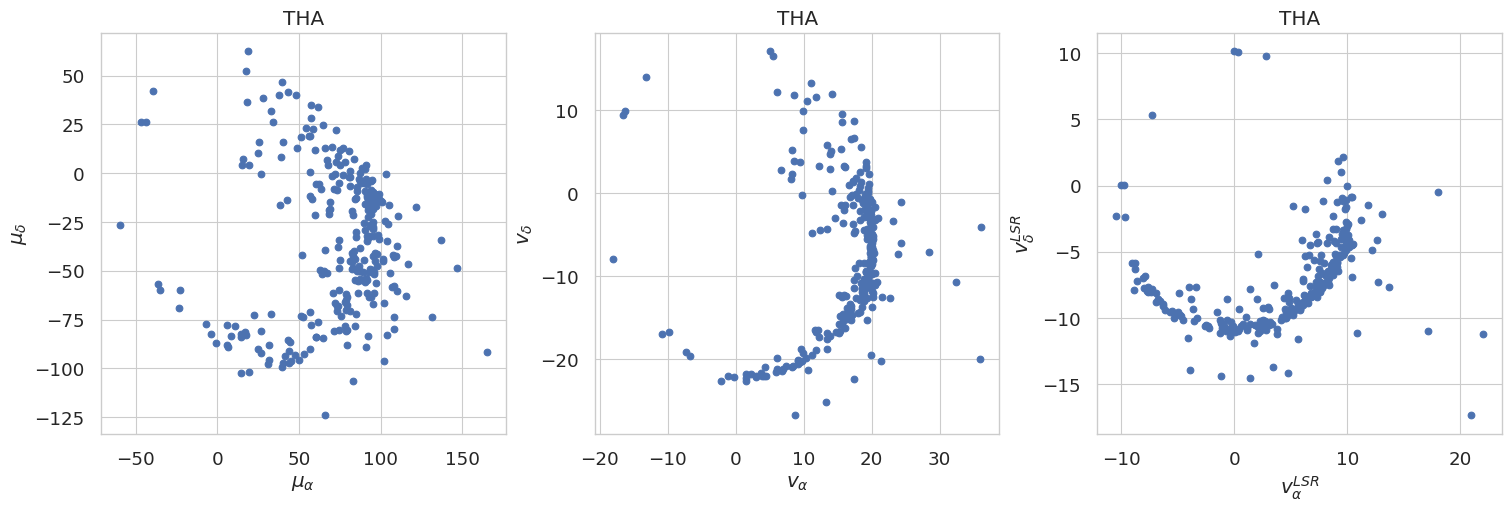

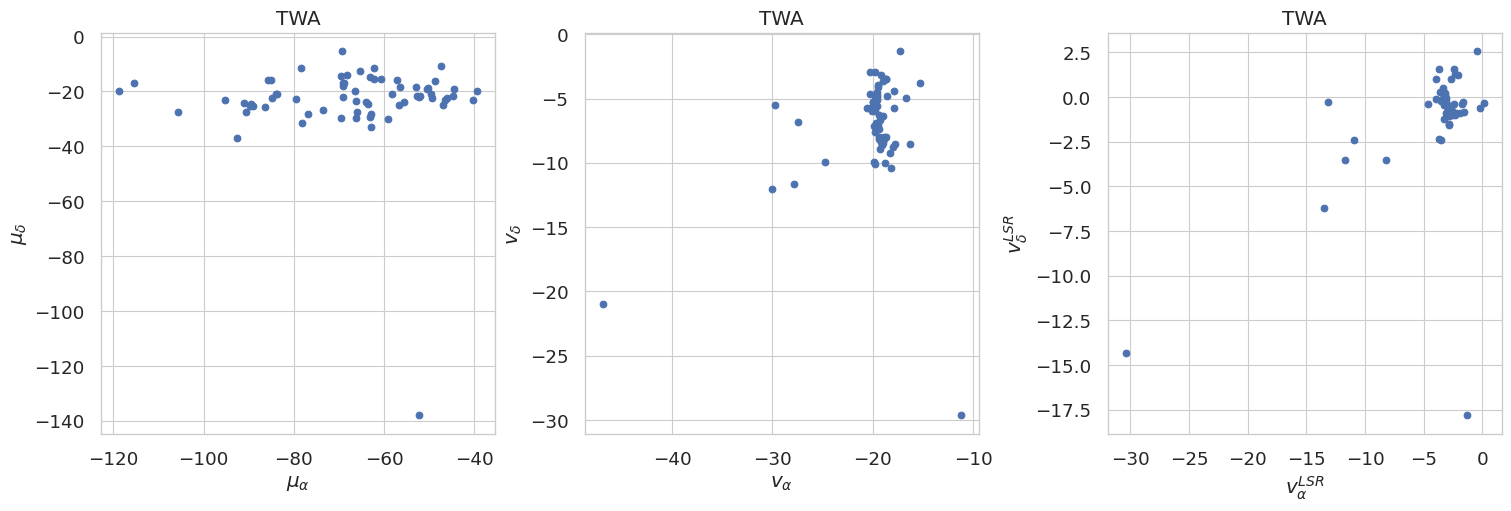

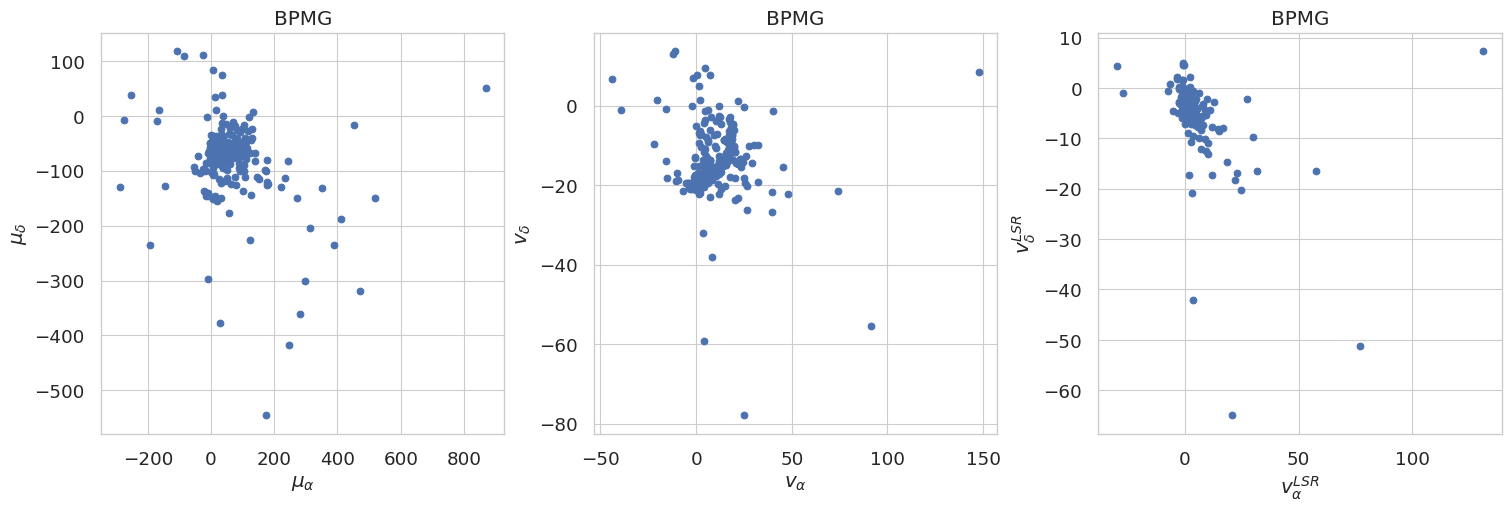

In [20]:
Av = 4.74047
for i in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
    nymgName = mocaGdr3Match.moca_aid.unique()[i]
    nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]

    fig, axs = plt.subplots(1,3,figsize=(15,5),constrained_layout=True)
    fig=plt.figure(1)

    ax = axs[0]
    ax.scatter(nymg.pmra,nymg.pmdec,label=nymgName)
    # ax.set_xlim(0,360)
    # ax.set_ylim(-90,90)
    ax.set_xlabel(r'$\mu_{\alpha}$')
    ax.set_ylabel(r'$\mu_{\delta}$')
    ax.set_title(nymgName)
    
    ax = axs[1]
    ax.scatter(Av*nymg.pmra/nymg.parallax,Av*nymg.pmdec/nymg.parallax,label=nymgName)
    # ax.set_xlim(0,360)
    # ax.set_ylim(-90,90)
    ax.set_xlabel(r'$v_{\alpha}$')
    ax.set_ylabel(r'$v_{\delta}$')
    ax.set_title(nymgName)
    
    ax = axs[2]
    ax.scatter(Av*nymg.pmraLSR/nymg.parallax,Av*nymg.pmdecLSR/nymg.parallax,label=nymgName)
    # ax.set_xlim(-100,200)
    # ax.set_ylim(-200,100)
    ax.set_xlabel(r'$v_{\alpha}^{LSR}$')
    ax.set_ylabel(r'$v_{\delta}^{LSR}$')
    ax.set_title(nymgName)

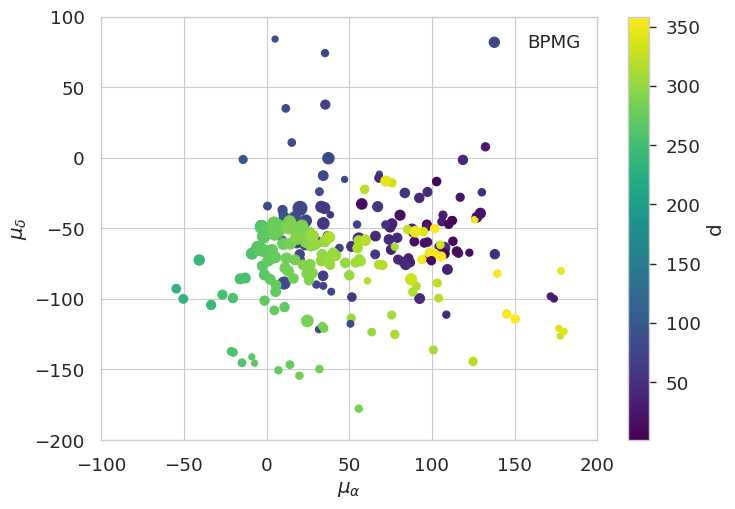

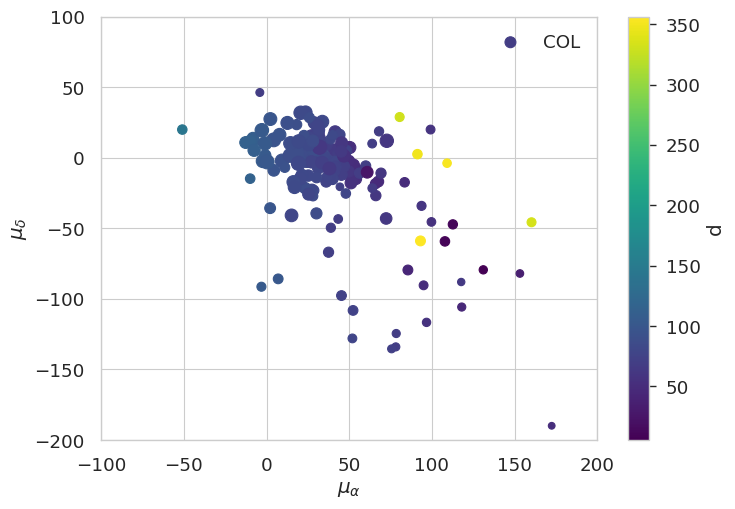

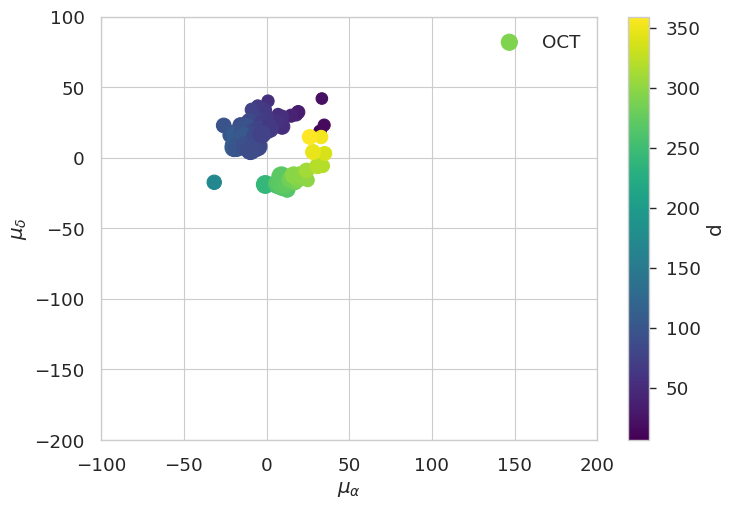

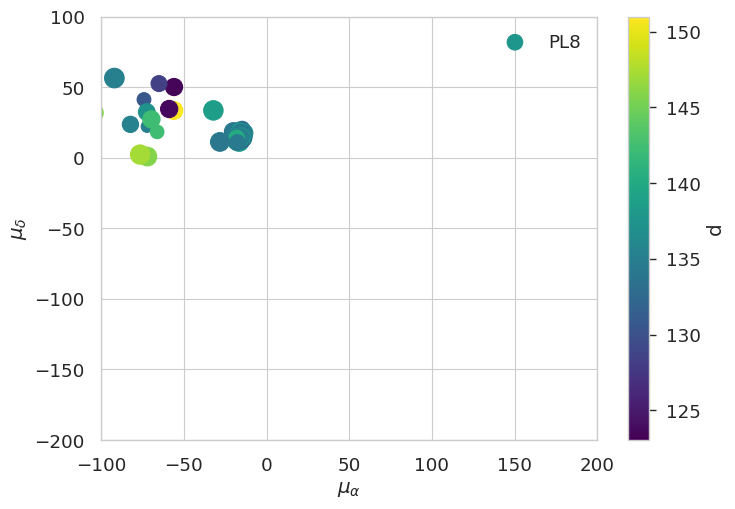

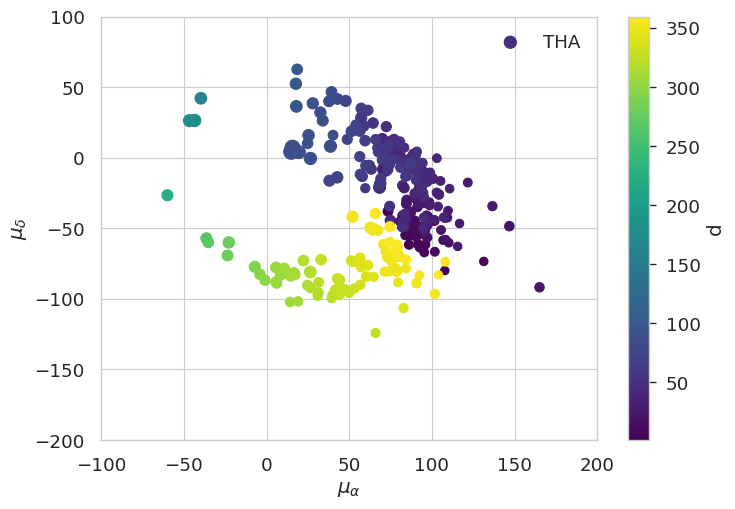

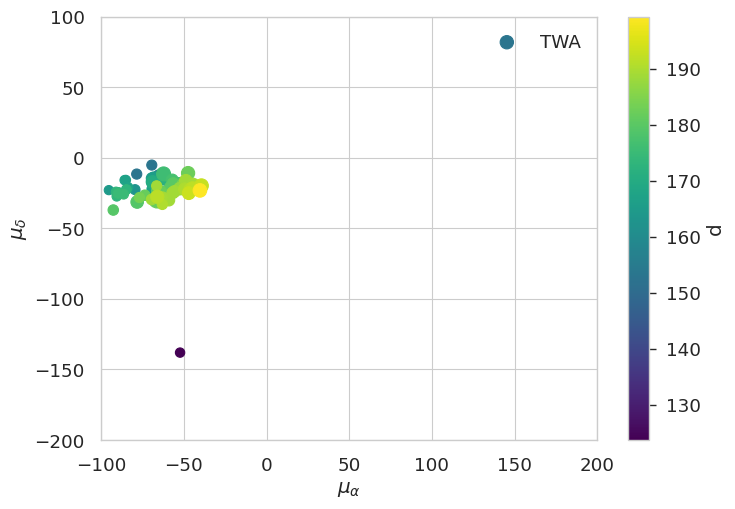

In [21]:
for i in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
    nymgName = mocaGdr3Match.moca_aid.unique()[i]
    nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]
    plt.scatter(nymg.pmra,nymg.pmdec,c=nymg.ra,label=nymgName,cmap='viridis',s=1000/nymg.parallax)
    plt.xlim(-100,200)
    plt.ylim(-200,100)
    plt.xlabel(r'$\mu_{\alpha}$')
    plt.ylabel(r'$\mu_{\delta}$')
    plt.colorbar(label=r'd')
    plt.legend()
    plt.show()

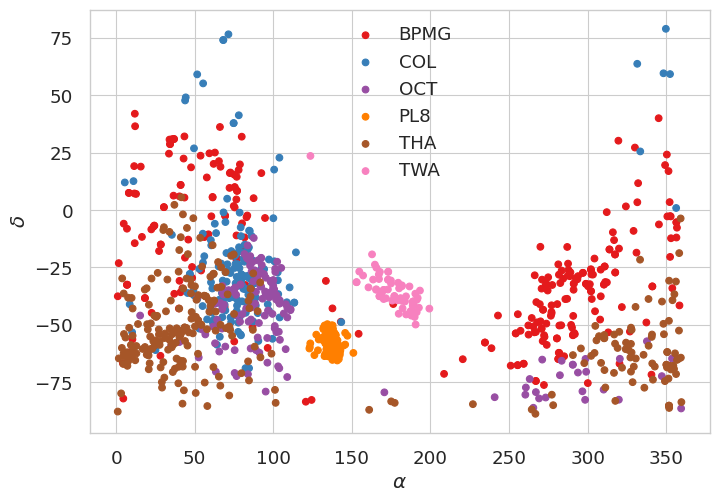

In [22]:
for i in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
    nymgName = mocaGdr3Match.moca_aid.unique()[i]
    nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]
    plt.scatter(nymg.ra,nymg.dec,c=i*np.ones(nymg.shape[0]),vmin=0,vmax=len(mocaGdr3Match.moca_aid.unique()),label=nymgName,cmap='Set1')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')
plt.legend()

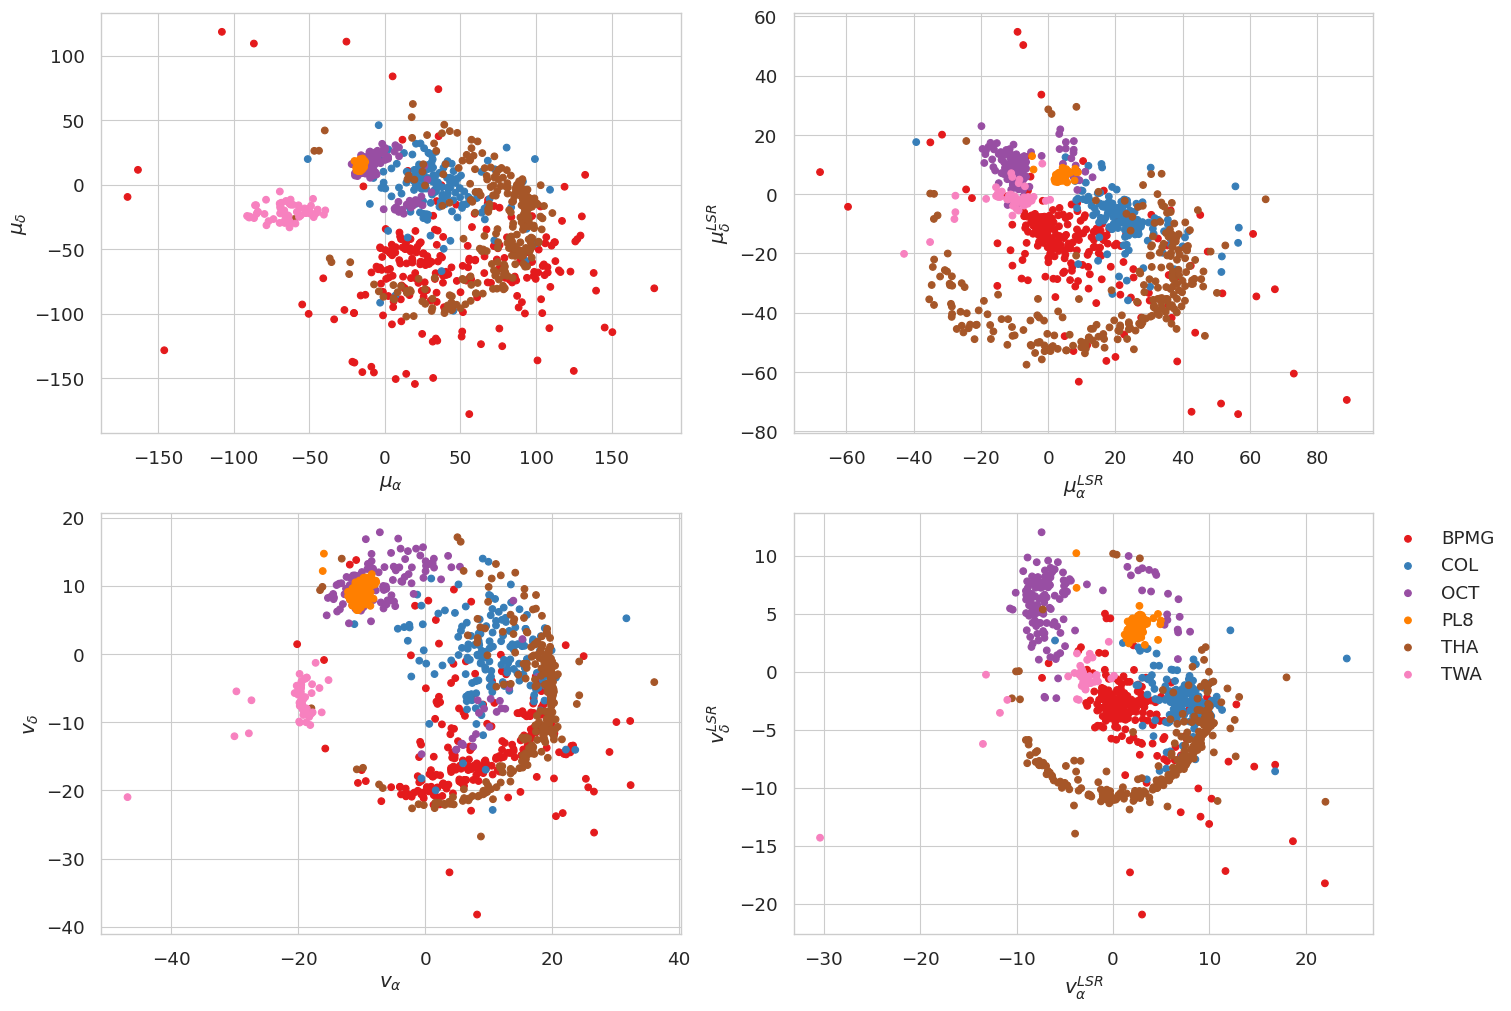

In [69]:
fig, axs = plt.subplots(2,2,figsize=(15,10),constrained_layout=True)
fig=plt.figure(1)

xcolumns = [['pmra','pmraLSR'],['vra','vraLSR']]
ycolumns = [['pmdec','pmdecLSR'],['vdec','vdecLSR']]
xlabels  = [[r'$\mu_{\alpha}$',r'$\mu_{\alpha}^{LSR}$'],[r'$v_{\alpha}$',r'$v_{\alpha}^{LSR}$']]
ylabels  = [[r'$\mu_{\delta}$',r'$\mu_{\delta}^{LSR}$'],[r'$v_{\delta}$',r'$v_{\delta}^{LSR}$']]
for i in [0,1]:
    for j in [0,1]:
        ax = axs[i,j]
        for k in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
            nymgName = mocaGdr3Match.moca_aid.unique()[k]
            nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]
            nymg     = nymg[np.sqrt(nymg.pmra**2+nymg.pmdec**2)<(np.sqrt(nymg.pmra**2+nymg.pmdec**2)).quantile(0.9)]
            ax.scatter(nymg[xcolumns[i][j]],nymg[ycolumns[i][j]],c=k*np.ones(nymg.shape[0]),vmin=0,vmax=len(mocaGdr3Match.moca_aid.unique()),label=nymgName,cmap='Set1')
            ax.set_xlabel(xlabels[i][j])
            ax.set_ylabel(ylabels[i][j])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.savefig('plots_and_images/2dKinematicsDistributionsComparison.jpg',bbox_inches='tight')

In [30]:
(1000/nymg.parallax).mean()

71.7558170085238

In [31]:
(nymg.pmra).std()

11.561836474832367

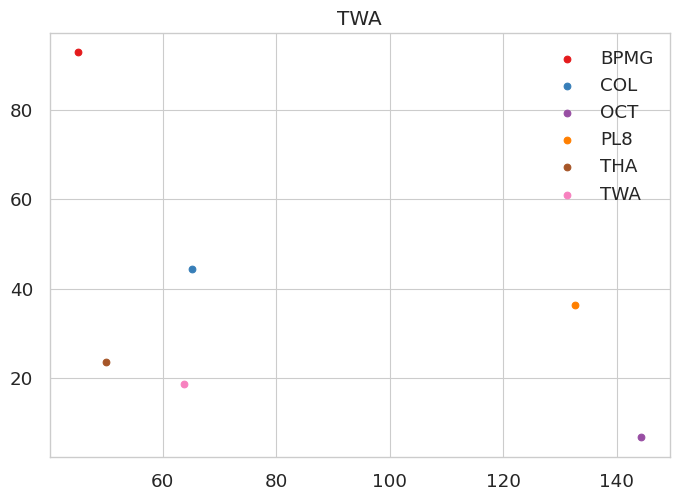

In [32]:
for i in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
    nymgName = mocaGdr3Match.moca_aid.unique()[i]
    nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]
    nymg     = nymg[np.sqrt(nymg.ra**2+nymg.dec**2)<(np.sqrt(nymg.ra**2+nymg.dec**2)).quantile(0.9)]
    plt.scatter((1000/nymg.parallax).mean(),np.std(np.sqrt(nymg.pmra**2+nymg.pmdec**2)),c=i,vmin=0,vmax=len(mocaGdr3Match.moca_aid.unique()),label=nymgName,cmap='Set1')
    # plt.xlim(-10,10)
    # plt.ylim(-200,200)
    plt.title(nymgName)
    # plt.show()
plt.legend()

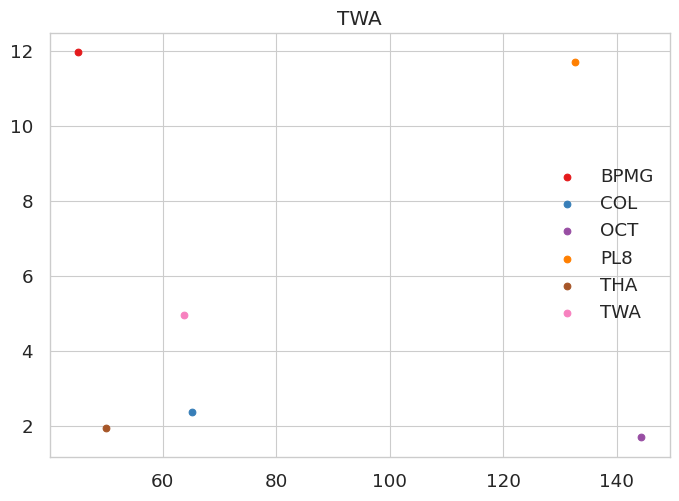

In [33]:
for i in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
    nymgName = mocaGdr3Match.moca_aid.unique()[i]
    nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]
    nymg     = nymg[np.sqrt(nymg.ra**2+nymg.dec**2)<(np.sqrt(nymg.ra**2+nymg.dec**2)).quantile(0.9)]
    plt.scatter((1000/nymg.parallax).mean(),np.std(np.sqrt((Av*nymg.pmraLSR/nymg.parallax)**2+(Av*nymg.pmdecLSR/nymg.parallax)**2)),c=i,vmin=0,vmax=len(mocaGdr3Match.moca_aid.unique()),label=nymgName,cmap='Set1')
    # plt.xlim(-10,10)
    # plt.ylim(-200,200)
    plt.title(nymgName)
    # plt.show()
plt.legend()

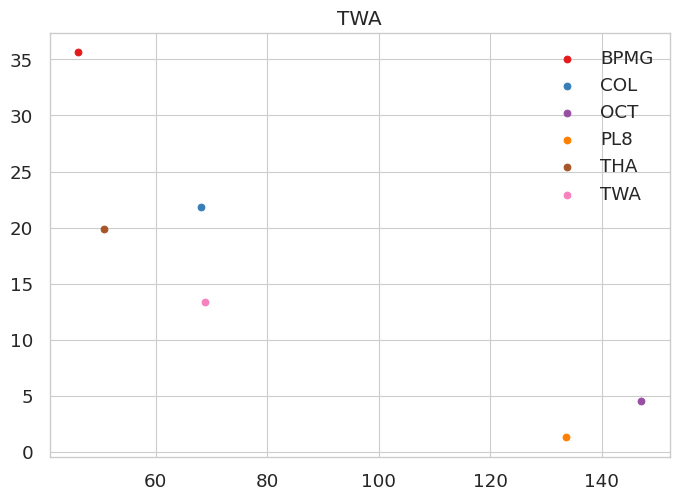

In [34]:
for i in np.arange(0,len(mocaGdr3Match.moca_aid.unique()),1):
    nymgName = mocaGdr3Match.moca_aid.unique()[i]
    nymg     = mocaGdr3Match[mocaGdr3Match.moca_aid == nymgName]
    nymg     = nymg[np.sqrt(nymg.pmra**2+nymg.pmdec**2)<(np.sqrt(nymg.pmra**2+nymg.pmdec**2)).quantile(0.9)]
    plt.scatter((1000/nymg.parallax).mean(),np.std(np.sqrt(nymg.pmra**2+nymg.pmdec**2)),c=i,vmin=0,vmax=len(mocaGdr3Match.moca_aid.unique()),label=nymgName,cmap='Set1')
    # plt.xlim(-10,10)
    # plt.ylim(-200,200)
    plt.title(nymgName)
    # plt.show()
plt.legend()

In [35]:
nymg.ra.quantile(0.9)

190.69584624651773

In [36]:
dfsvdfvdfbvdfb

NameError: name 'dfsvdfvdfbvdfb' is not defined

# Sigma clipping aplication to the desired NYMGs

In [ ]:
def sigmaClippingSelector(nymg,n,columns):
    for i in np.arange(0,len(columns),1):
        nymg = nymg[nymg[columns[i]]**2-nymg[columns[i]].median()**2 <= (n*nymg[columns[i]].std())**2]
    return nymg

In [ ]:
names = finalNymgsStats.NYMG
for i in np.arange(0,len(names),1):
    name = names[i]
    nymg = finalNymgsMatch[finalNymgsMatch.YNMG == name]
    plt.scatter(nymg.BR,nymg.MG)
    plt.ylim(15,-1)
    plt.show()
    plt.scatter(nymg.U,nymg.V)
    nymg = sigmaClippingSelector(nymg,2,['X','Y','Z','U','V','W'])
    plt.scatter(nymg.U,nymg.V)
    plt.xlim(-200,200)
    plt.ylim(-200,200)
    plt.show()
    plt.scatter(nymg.BR,nymg.MG)
    plt.ylim(15,-1)
    plt.show()
    for j in np.arange(4,len(statsColumns),1):
        finalNymgsStats[statsColumns[j]].iloc[i] = nymg[statsColumns[j][3]].std()

In [ ]:
import mass_photometry_tools as massPhoto
bpmg = nymgsMatchGdr3[nymgsMatchGdr3.YNMG == 'BPMG']
bpmg['MG'] = bpmg.phot_g_mean_mag+5-5*np.log10(1000/bpmg.parallax)
bpmg['BR'] = bpmg.phot_bp_mean_mag-bpmg.phot_rp_mean_mag
bpmgiso = massPhoto.isochroneSelector(data           = bpmg,
                                                      age            = 20000000.0,
                                                      deltaMag       =  [1e6,0.5],
                                                      dataMagName    = 'MG',
                                                      dataColorNames = ['phot_bp_mean_mag','phot_rp_mean_mag'])

bpmg.to_csv('BPMG.csv',index=False)
bpmgiso.to_csv('BPMG_20.csv',index=False)

In [ ]:
finalNymgsStats

In [ ]:
nymgsMatchGdr3.to_csv('nymgs_gdr3_match.csv',index=False)

finalNymgsStats.to_csv('statsForSyntheticNymgs.csv',index=False)